This notebook: can we use the outputs of `to_cdr` to reproduce the epoched data / ERP results from the control?

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2eepch9_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [89]:
# CDR_OUTPUT_DIR = Path("../work/c0/e17e6385700b9d22bdfce8b5d25eb5")
# CDR_X = CDR_OUTPUT_DIR / "X.txt"
# CDR_Y = CDR_OUTPUT_DIR / "y.txt"
# DATASET_SPLIT_TARGET = None
# UNIVARIATE_RESPONSE = False

# Subset fit data
CDR_OUTPUT_DIR = Path("../work/0d/1c849c11642f62c70766b725592872")
CDR_X = CDR_OUTPUT_DIR / "X_subset.txt"
CDR_Y = CDR_OUTPUT_DIR / "y_subset.train.txt"
DATASET_SPLIT_TARGET = "train"
UNIVARIATE_RESPONSE = True

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = [f"el{x}" for x in ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]]

In [56]:
X = pd.read_csv(CDR_X, sep=" ", index_col="index")

In [57]:
more = []
for (subject, item, word_idx), rows in X.groupby(["subject", "item", "word_idx"]):
    if len(rows) > 1:
        more.append(((subject, item, word_idx), rows))

In [58]:
more

# TODO work this out ..

[]

In [59]:
y = pd.read_csv(CDR_Y, sep=" ", index_col=None).set_index(["subject", "item"])

In [60]:
# Zero out clock at the start of each item.
item_times = pd.DataFrame(X.groupby(["subject", "item"]).time.min())
item_times["y_time"] = y.groupby(["subject", "item"]).time.min()
item_times["min_time"] = item_times.fillna(0.0).min(axis=1)
X.time -= X.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time
y.time -= y.merge(item_times, how="left", left_on=["subject", "item"], right_index=True).min_time

In [61]:
X

,subject,onset_time,word_idx,sentence_idx,subject_idx,presentation_idx,index.1,word,surprisal,word_len,word_freq,item,time,modulus,target
index,,,,,,,,,,,,,,,
2,1,10.496,1,105,1,141.0,763.0,heaved,16.760948,6.0,-12.582876,105,0.772,2,dev
3,1,11.236,2,105,1,141.0,764.0,his,3.229763,3.0,-5.442780,105,1.512,2,dev
4,1,11.924,3,105,1,141.0,765.0,shoulders,5.293627,9.0,-10.088430,105,2.200,2,dev
5,1,12.720,4,105,1,141.0,766.0,and,3.803340,3.0,-3.657424,105,2.996,2,dev
6,1,13.408,5,105,1,141.0,767.0,swung,9.167073,5.0,-10.930905,105,3.684,2,dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,24,1986.184,6,140,24,51.0,1125.0,neck,1.573041,4.0,-9.832292,140,4.368,0,train
2125,24,1986.880,7,140,24,51.0,1126.0,and,3.388201,3.0,-3.657424,140,5.064,0,train
2126,24,1987.568,8,140,24,51.0,1127.0,hung,10.085722,4.0,-10.386361,140,5.752,0,train


In [62]:
y

run_sample_id   time      VEOG     HEOG       50       36  \
subject item                                                              
1       168            5314  0.000 -114.1145  -5.6409 -37.8446 -50.6907   
        168            5315  0.004 -110.4351  -2.4435 -36.2298 -48.4573   
        168            5316  0.008 -107.0020   0.2648 -34.9832 -46.7111   
        168            5317  0.012 -104.0003   2.2991 -34.0461 -45.3963   
        168            5318  0.016 -102.2792   3.4135 -33.5427 -44.6382   
...                     ...    ...       ...      ...      ...      ...   
24      140          497464  8.040   42.0969 -30.3438  13.7582  -0.2792   
        140          497465  8.044   43.9587 -26.3807  10.3400  -2.3959   
        140          497466  8.048   46.6879 -21.7906   5.9230  -5.6234   
        140          497467  8.052   49.9680 -17.3883   1.3177  -8.5422   
        140          497468  8.056   53.6102 -13.6123  -1.9126 -10.1014   

                   49       37      48       38  ...       22       18  \
subject item                                     ...                     
1       168  -12.2552 -33.5461 -8.1054 -32.0812  ... -28.1249  -5.7586   
        168  -10.5206 -31.8218 -6.5156 -30.1125  ... -25.4162  -2.6825   
        168   -9.2763 -30.7126 -5.2961 -28.0211  ... -22.5865   0.0257   
        168   -8.3414 -30.0348 -4.6317 -25.9919  ... -19.9433   2.3027   
        168   -7.9618 -29.6655 -4.5207 -24.2708  ... -17.8548   3.6597   
...               ...      ...     ...      ...  ...      ...      ...   
24      140    0.2966   9.7130  4.4352  -8.1162  ... -23.4722 -10.7929   
        140    0.8803  12.4245  4.2215  -8.0552  ... -22.5178  -9.0729   
        140    0.5889  13.2417  4.6421  -7.6151  ... -21.1849  -6.6017   
        140   -0.5177  11.8487  5.6348  -6.6070  ... -19.4125  -3.6952   
        140   -1.8765   8.9403  7.5191  -4.9676  ... -17.2641  -0.6673   

                   10       16       12       35        8  mean_response  \
subject item                                                               
1       168  -24.9322   6.0432 -13.1568 -62.4152 -24.2064        -8.6226   
        168  -21.8561   9.1192 -10.4450 -60.3095 -21.1303        -6.5648   
        168  -18.7845  11.8298  -7.4939 -58.4503 -18.3007        -4.6593   
        168  -16.0233  13.8708  -4.4885 -56.9010 -15.9023        -2.9496   
        168  -13.8183  15.1156  -1.7960 -55.6651 -14.1812        -1.6510   
...               ...      ...      ...      ...      ...            ...   
24      140  -25.0604   3.9225 -14.2745 -12.5113 -41.4400         6.0862   
        140  -24.9481   0.6693 -16.0440 -12.0283 -38.3497         4.4014   
        140  -24.8311  -2.2113 -18.0590 -10.1748 -35.0063         2.7934   
        140  -24.4049  -4.4368 -20.3864  -6.8946 -31.7261         1.4851   
        140  -23.8587  -6.0768 -22.7168  -2.8734 -28.6982         0.4748   

              modulus  target  
subject item                   
1       168         1   train  
        168         1   train  
        168         1   train  
        168         1   train  
        168         1   train  
...               ...     ...  
24      140         0   train  
        140         0   train  
        140         0   train  
        140         0   train  
        140         0   train  

[1539891 rows x 27 columns]

---

In [105]:
epoch_data = []

X_tgt = X
if DATASET_SPLIT_TARGET is not None:
    X_tgt = X_tgt[X_tgt.target == DATASET_SPLIT_TARGET]
grouper = X_tgt.groupby(["subject", "item", "word_idx"])
for (subject, item, word_idx), rows in tqdm(grouper, total=grouper.ngroups):
    # TODO should always be 1 row.
    if len(rows) > 1:
        print(f"Warning: {len(rows)} rows for {(subject, item, word_idx)}.")
    x = rows.iloc[0]
    
    try:
        y_df = y.loc[subject].loc[item]
    except KeyError:
        # Response df is a train split of a larger dataset. Missing data is fine.
        pass
    
    epoch_left, epoch_right = EPOCH_WINDOW
    epoch_window = y_df[(y_df.time >= x.time + epoch_left) & (y_df.time <= x.time + epoch_right)]
    
    baseline_window = epoch_window[epoch_window.time <= x.time]
    
    test_left, test_right = TEST_WINDOW
    test_window = epoch_window[(epoch_window.time >= x.time + test_left) & (epoch_window.time <= x.time + test_right)]
    
    if UNIVARIATE_RESPONSE:
        baseline_window = baseline_window.mean_response
        test_window = test_window.mean_response
    else:
        # subset electrodes
        baseline_window = baseline_window[N400_ELECTRODES]
        test_window = test_window[N400_ELECTRODES]
    
    # take means
    baseline_window = baseline_window.mean(axis=0)
    test_window = test_window.mean(axis=0)
    
    if not UNIVARIATE_RESPONSE:
        # Avg over electrodes
        baseline_window = baseline_window.mean()
        test_window = test_window.mean()
    
    epoch_data.append((subject, item, x.word_idx, baseline_window, test_window))

  0%|          | 0/6328 [00:00<?, ?it/s]

In [106]:
epoch_df = pd.DataFrame(epoch_data, columns=["subject_idx", "sentence_idx", "word_idx", "cdr_base_N400", "cdr_value_N400"]) \
    .set_index(["subject_idx", "sentence_idx", "word_idx"])
epoch_df

cdr_base_N400  cdr_value_N400
subject_idx sentence_idx word_idx                               
1           7            1             11.149680        8.315772
                         2              9.818280       -8.047790
                         3            -11.338840       -9.364730
                         4             -8.188336       -6.508910
            15           1             -6.050108       -2.336842
...                                          ...             ...
24          200          10            -6.614772       -8.666954
                         11           -10.302972       -0.267838
                         12            -6.774592        4.453426
                         13            -0.440308       -0.251734
                         14             2.905632        4.852982

[6328 rows x 2 columns]

-----

In [107]:
REFERENCE_DATASET = Path("../output/frank2015/erp/erp_full.csv")
reference_df = pd.read_csv(REFERENCE_DATASET, index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  ...  \
subject_idx sentence_idx word_idx                                    ...   
1           1            0                3.145689         3.121044  ...   
                         1                8.214565         7.030273  ...   
                         2                8.330564         6.914139  ...   
                         3                3.210452         2.787990  ...   
                         4                8.541803         8.242652  ...   
...                                            ...              ...  ...   
24          205          7                3.924689         3.901125  ...   
                         8                7.945024         6.722867  ...   
                         9                9.959173         8.835783  ...   
                         10               3.884360         3.874658  ...   
                         11               8.574935         8.116138  ...   

                                   surp_rnn_size_6  surp_rnn_size_

---

## Compare with pre-packaged ERP data

From Frank et al 2015 dataset

In [108]:
comp_df = pd.merge(epoch_df, reference_df, how="left", left_index=True, right_index=True)
comp_df

cdr_base_N400  cdr_value_N400  value_N400  \
subject_idx sentence_idx word_idx                                              
1           7            1             11.149680        8.315772    2.832397   
                         2              9.818280       -8.047790   -8.094505   
                         3            -11.338840       -9.364730   -4.457937   
                         4             -8.188336       -6.508910    0.035155   
            15           1             -6.050108       -2.336842   -4.613079   
...                                          ...             ...         ...   
24          200          10            -6.614772       -8.666954   -3.093866   
                         11           -10.302972       -0.267838    3.128957   
                         12            -6.774592        4.453426    4.719037   
                         13            -0.440308       -0.251734   -1.995819   
                         14             2.905632        4.852982    3.336179   

                                   base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                
1           7            1          4.353407         0       0   
                         2          5.981127         1       1   
                         3         -9.515251         0       0   
                         4         -2.318755         0       1   
            15           1        -10.214387         0       0   
...                                      ...       ...     ...   
24          200          10        -0.515853         0       0   
                         11        -5.444414         0       0   
                         12        -4.519414         0       0   
                         13        -0.788622         0       0   
                         14         1.172338         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           7            1                   9.296089            9.770836   
                         2                   2.620848            2.612881   
                         3                   6.664810            7.305987   
                         4                   1.283477            0.883497   
            15           1                  10.734951           11.301617   
...                                               ...                 ...   
24          200          10                  6.569506            7.148421   
                         11                  9.690314           10.165222   
                         12                  2.147573            2.140902   
                         13                  2.174838            1.724130   
                         14                  5.022698            3.936016   

                                   surp_ngram_order_4  surp_rnn_size_1  ...  \
subject_idx sentence_idx word_idx                                       ...   
1           7            1                   9.826052         9.076217  ...   
                         2                   2.612881         3.284885  ...   
                         3                   7.457544         8.331858  ...   
                         4                   0.874365         9.158985  ...   
            15           1                  11.564665         9.248528  ...   
...                                               ...              ...  ...   
24          200          10                  7.260903         8.894570  ...   
                         11                 10.254056         9.938900  ...   
                         12                  2.140902         7.787814  ...   
                         13                  1.688297         2.189939  ...   
                         14                  3.178857         7.372717  ...   

                                   surp_rnn_size_6  surp_rnn_size_7  \
subject_idx sentence_idx word_idx 

<AxesSubplot:xlabel='cdr_value_N400', ylabel='value_N400'>

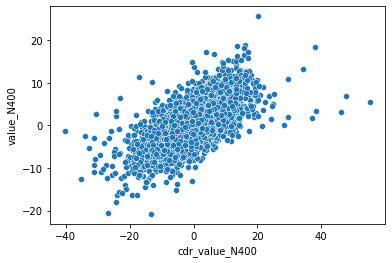

In [109]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="value_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='base_N400'>

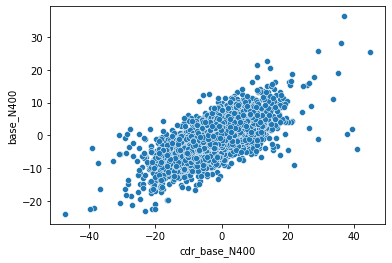

In [110]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="base_N400")

In [111]:
import scipy.stats

In [112]:
scipy.stats.pearsonr(comp_df.value_N400, comp_df.cdr_value_N400)

(0.6589954949230821, 0.0)

In [113]:
scipy.stats.pearsonr(comp_df.base_N400, comp_df.cdr_base_N400)

(0.697238871691737, 0.0)

Just as before, it's not a perfect correlation -- there is preprocessing done in Frank et al., e.g. the modulus transformation, not done in our pipeline -- but things look pretty good.

---

## Compare with our own MNE-based ERP data

<AxesSubplot:xlabel='cdr_value_N400', ylabel='our_N400'>

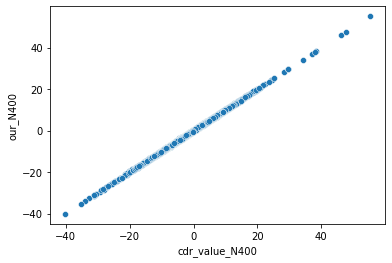

In [114]:
sns.scatterplot(data=comp_df, x="cdr_value_N400", y="our_N400")

<AxesSubplot:xlabel='cdr_base_N400', ylabel='our_baseline'>

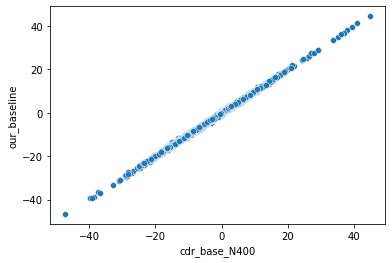

In [115]:
sns.scatterplot(data=comp_df, x="cdr_base_N400", y="our_baseline")

In [116]:
scipy.stats.pearsonr(comp_df.cdr_value_N400, comp_df.our_N400)

(0.99982782708147, 0.0)

In [117]:
scipy.stats.pearsonr(comp_df.cdr_base_N400, comp_df.our_baseline)

(0.9994377069779299, 0.0)

Perfect.